In [42]:
import numpy as np

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, Autoformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df

from neuralforecast.losses.pytorch import MAE

In [58]:

AirPassengersPaneld, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')

Y_train_df = AirPassengersPaneld[AirPassengersPaneld.ds<AirPassengersPaneld['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPaneld[AirPassengersPaneld.ds>=AirPassengersPaneld['ds'].values[-12]].reset_index(drop=True) # 12 test

Y_train_df=Y_train_df.drop(['ds','trend','y_[lag12]'],axis=1)
Y_test_df=Y_test_df.drop(['ds','trend','y_[lag12]'],axis=1)

print(calendar_cols)

['month']


In [59]:
AirPassengersPaneld

,unique_id,ds,y,trend,y_[lag12],month
0,Airline1,1949-01-31,112.0,0,112.0,-0.500000
1,Airline1,1949-02-28,118.0,1,118.0,-0.409091
2,Airline1,1949-03-31,132.0,2,132.0,-0.318182
3,Airline1,1949-04-30,129.0,3,129.0,-0.227273
4,Airline1,1949-05-31,121.0,4,121.0,-0.136364
...,...,...,...,...,...,...
283,Airline2,1960-08-31,906.0,283,859.0,0.136364
284,Airline2,1960-09-30,808.0,284,763.0,0.227273
285,Airline2,1960-10-31,761.0,285,707.0,0.318182
286,Airline2,1960-11-30,690.0,286,662.0,0.409091


In [60]:
Y_test_df

,unique_id,y,month
0,Airline1,417.0,-0.500000
1,Airline1,391.0,-0.409091
2,Airline1,419.0,-0.318182
3,Airline1,461.0,-0.227273
4,Airline1,472.0,-0.136364
5,Airline1,535.0,-0.045455
6,Airline1,622.0,0.045455
7,Airline1,606.0,0.136364
8,Airline1,508.0,0.227273
9,Airline1,461.0,0.318182


In [61]:

model = Autoformer(h=12,
                 input_size=24,
                 hidden_size = 16,
                 conv_hidden_size = 32,
                 n_head=2,
                 loss=MAE(),
                 futr_exog_list=calendar_cols,
                 scaler_type='robust',
                 learning_rate=1e-3,
                 max_steps=300,
                 val_check_steps=50,
                 early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)

Global seed set to 1


In [62]:
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)

KeyError: "None of ['ds'] are in the columns"

In [51]:
forecasts = nf.predict(futr_df=Y_test_df)

Predicting: 0it [00:00, ?it/s]

In [52]:
Y_test_df

,unique_id,ds,y,month
0,Airline1,1960-01-31,417.0,-0.500000
1,Airline1,1960-02-29,391.0,-0.409091
2,Airline1,1960-03-31,419.0,-0.318182
3,Airline1,1960-04-30,461.0,-0.227273
4,Airline1,1960-05-31,472.0,-0.136364
5,Airline1,1960-06-30,535.0,-0.045455
6,Airline1,1960-07-31,622.0,0.045455
7,Airline1,1960-08-31,606.0,0.136364
8,Airline1,1960-09-30,508.0,0.227273
9,Airline1,1960-10-31,461.0,0.318182


In [53]:
forecasts

,ds,Autoformer
unique_id,,
Airline1,1960-01-31,407.213226
Airline1,1960-02-29,408.232025
Airline1,1960-03-31,447.086182
Airline1,1960-04-30,448.556549
Airline1,1960-05-31,453.166901
Airline1,1960-06-30,503.543854
Airline1,1960-07-31,591.610657
Airline1,1960-08-31,605.109619
Airline1,1960-09-30,530.382874


In [54]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)

In [55]:
plot_df

,ds,y,month,Autoformer
0,1949-01-31,112.0,-0.500000,NaN
1,1949-02-28,118.0,-0.409091,NaN
2,1949-03-31,132.0,-0.318182,NaN
3,1949-04-30,129.0,-0.227273,NaN
4,1949-05-31,121.0,-0.136364,NaN
...,...,...,...,...
7,1960-08-31,606.0,0.136364,605.109619
8,1960-09-30,508.0,0.227273,530.382874
9,1960-10-31,461.0,0.318182,456.241760
10,1960-11-30,390.0,0.409091,408.948456


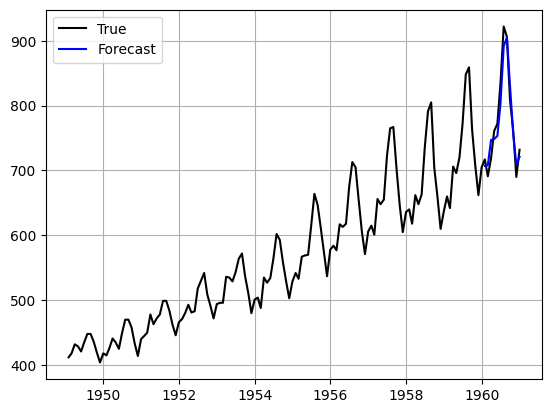

In [56]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline2'].drop('unique_id', axis=1)

plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
# plt.plot(plot_df['y'].values, c='black', label='True')
plt.plot(plot_df['ds'], plot_df['Autoformer'], c='blue', label='Forecast')

plt.legend()
plt.grid()
plt.show()
